<a href="https://colab.research.google.com/github/mkbahk/QuantumComputing/blob/main/QuantumToyAlgorithm_QPE_00_Grok2_mkbahk_20250424.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install qiskit[visualization]==1.2.4
%pip install qiskit-aer==0.15.1
%pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

  Cloning https://github.com/qiskit-community/qiskit-textbook.git to /tmp/pip-req-build-mq0qhi6w
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/qiskit-textbook.git /tmp/pip-req-build-mq0qhi6w
  Resolved https://github.com/qiskit-community/qiskit-textbook.git to commit 0ae905083ec3872d7ddc6bb4001d5468f476d93f
  Preparing metadata (setup.py) ... done


In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector
from qiskit_textbook.tools import array_to_latex
from qiskit_aer import Aer
from IPython.display import display, Math
import numpy as np
#import matplotlib.pyplot as plt

In [3]:
# 카운팅 큐비트 수와 타겟 큐비트 수 정의
n_counting_qubits = 3  # 위상 추정을 위해 사용할 카운팅 큐비트 수
n_total_qubits = n_counting_qubits + 1  # 전체 큐비트 수 (카운팅 + 타겟)

# 양자 회로 생성
qc = QuantumCircuit(n_total_qubits, n_counting_qubits)  # 양자 회로 객체 초기화: 큐비트와 고전 비트 지정

# 타겟 큐비트를 T 게이트의 고유 상태(|1⟩ 상태)로 초기화
qc.x(n_counting_qubits)  # 타겟 큐비트에 X 게이트 적용하여 |0⟩ → |1⟩로 전환

# 모든 카운팅 큐비트에 하다마드 게이트 적용
for qubit in range(n_counting_qubits):  # 0부터 n_counting_qubits-1까지 반복
    qc.h(qubit)  # 하다마드 게이트로 카운팅 큐비트를 중첩 상태로 만듦

# 제어 T 게이트를 반복적으로 적용 (위상 증가)
for counting_qubit in range(n_counting_qubits):  # 각 카운팅 큐비트에 대해
    for _ in range(2 ** (n_counting_qubits - counting_qubit - 1)):  # 2^(n-k-1)번 반복
        qc.cp(np.pi / 4, counting_qubit, n_total_qubits - 1)  # 제어 T 게이트 (위상 π/4) 적용

# 역 양자 푸리에 변환 (QFT†) 함수 정의
def inverse_qft(qc, n):  # 역 QFT를 적용할 함수
    # 큐비트 순서 뒤집기 (스왑 연산)
    for qubit in range(n // 2):  # 절반만 스왑하면 전체 순서 반전됨
        qc.swap(qubit, n - qubit - 1)  # 두 큐비트 위치 교환
    # 위상 조정과 하다마드 게이트 적용
    for j in range(n):  # 모든 큐비트에 대해
        for m in range(j):  # j 이전의 큐비트들과 상호작용
            qc.cp(-np.pi / float(2 ** (j - m)), m, j)  # 역방향 위상 게이트 적용
        qc.h(j)  # 하다마드 게이트로 중첩 해제

# 카운팅 큐비트에 역 QFT 적용
inverse_qft(qc, n_counting_qubits)  # 위에서 정의한 함수 호출

# 카운팅 큐비트 측정
qc.measure(range(n_counting_qubits), range(n_counting_qubits))  # 카운팅 큐비트를 고전 비트에 기록

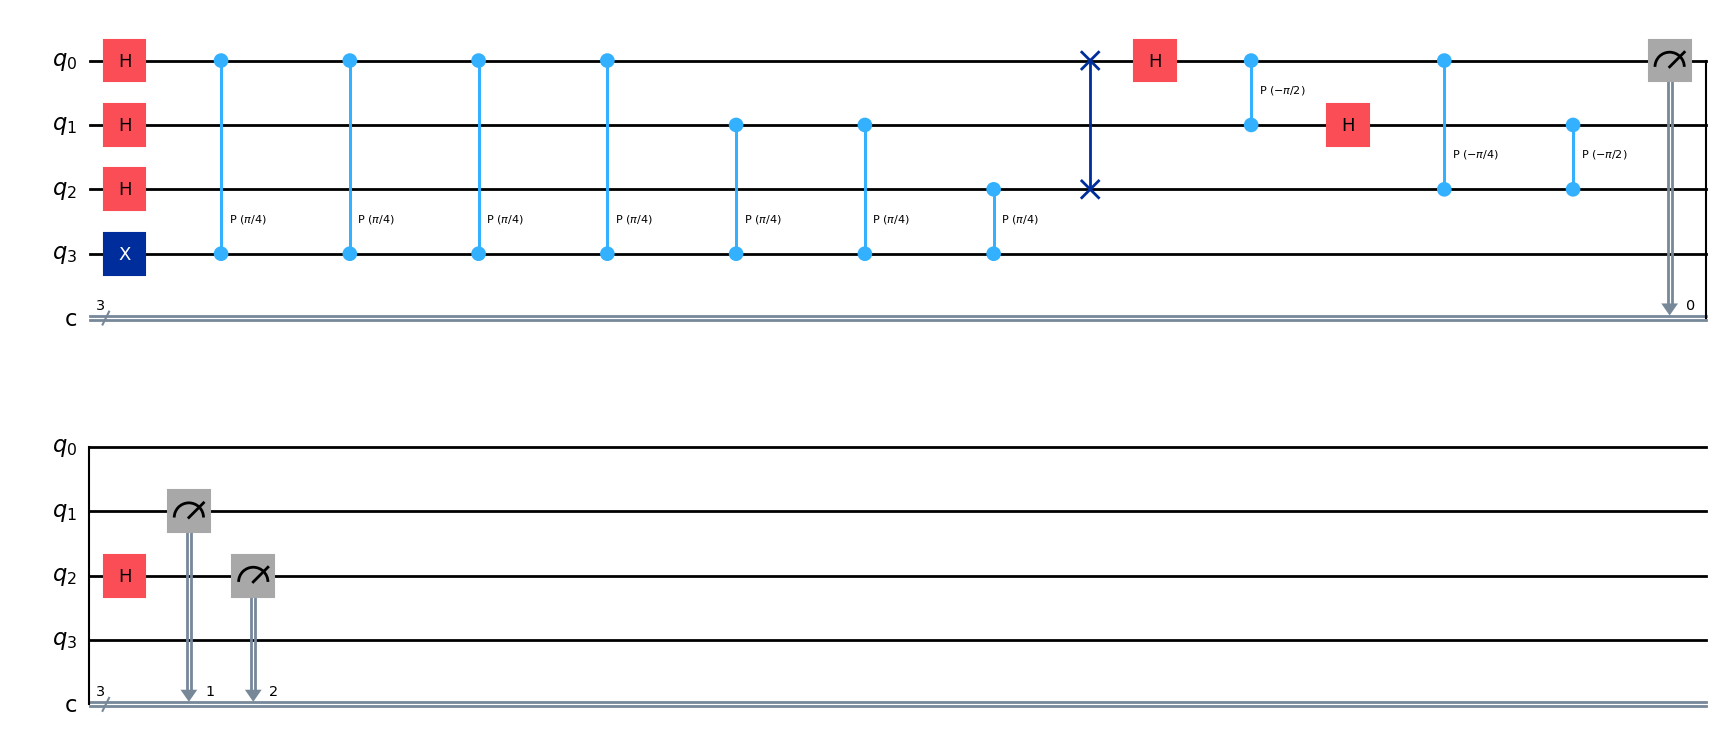

In [4]:
qc.draw("mpl")

In [5]:
# 시뮬레이터 설정 및 실행
simulator = Aer.get_backend('qasm_simulator')

tqc = transpile(qc, simulator)
#qobj = assemble(tqc)

result = simulator.run(tqc, shots=1024).result()
counts = result.get_counts()

# 결과 출력
print(counts)

{'001': 17, '101': 149, '110': 204, '010': 220, '100': 434}


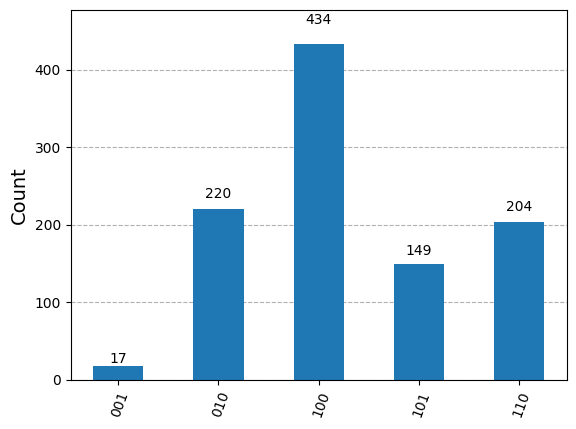

In [6]:
plot_histogram(counts)

In [7]:
# 결과 출력
print("측정 결과:", counts)

# 결과 해석 및 실제 값과 비교
# T 게이트의 실제 위상: π/4 (약 0.7854 라디안, 분수로 1/8 = 0.125)
actual_phase = 1 / 8  # T 게이트의 실제 위상 (0 ~ 1 범위)
print(f"실제 위상 (0~1): {actual_phase}")

# 가장 빈번한 측정 결과를 찾아 위상 추정
most_frequent_state = max(counts, key=counts.get)  # 가장 많이 나온 상태 (이진수 문자열)
measured_value = int(most_frequent_state, 2)  # 이진수를 십진수로 변환
estimated_phase = measured_value / (2 ** n_counting_qubits)  # 추정된 위상 계산
print(f"가장 빈번한 결과: {most_frequent_state} (십진수: {measured_value})")
print(f"추정된 위상 (0~1): {estimated_phase}")

# 오차 계산
error = abs(actual_phase - estimated_phase)
print(f"오차: {error}")

측정 결과: {'001': 17, '101': 149, '110': 204, '010': 220, '100': 434}
실제 위상 (0~1): 0.125
가장 빈번한 결과: 100 (십진수: 4)
추정된 위상 (0~1): 0.5
오차: 0.375


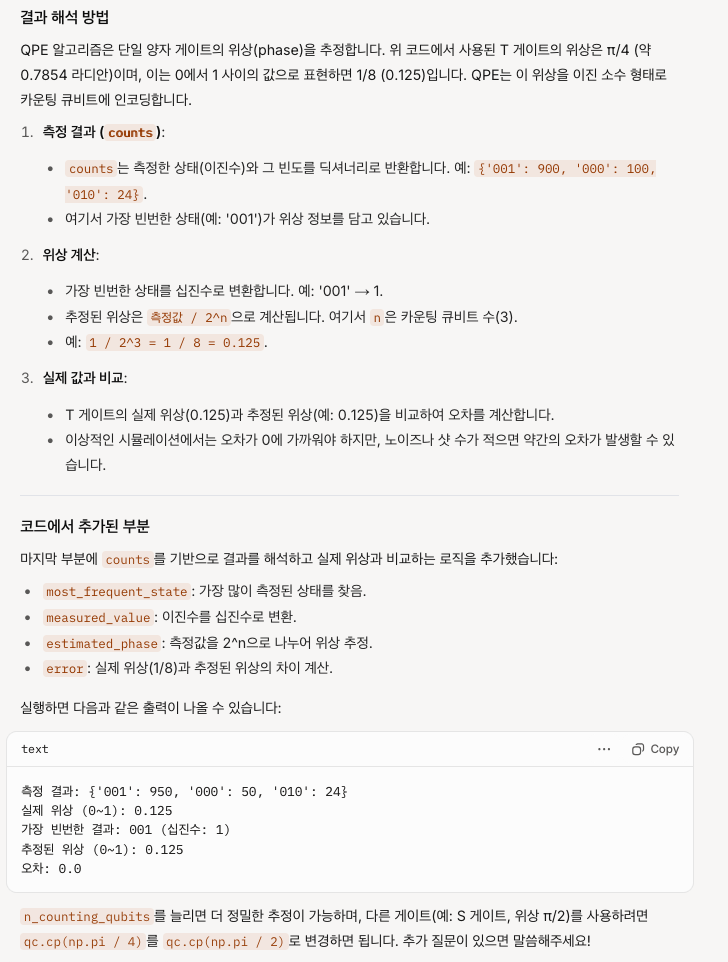